In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
qDate = session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1)
dateNew = ""
# for items in qDate:
#     dateNew = items[0]
#     print(dateNew)

dateNew = qDate[0][0]

dateNew = dateNew.split("-")

# for items in dateNew:
#     print(items)

dateOld = []

dateOld.append(str(int(dateNew[0]) - 1))

# print(dateOld[0])

dateOld.append(dateNew[1])
dateOld.append(dateNew[2])

# for items in dateOld:
#     print(items)

dateOld = "-".join(dateOld)

print(f"Older date: {dateOld}")

dateNew = "-".join(dateNew)

print(f"Newer date: {dateNew}")

# Calculate the date 1 year ago from the last data point in the database
prcpData = session.query(Measurement.date, func.sum(Measurement.prcp))\
.filter(Measurement.date > dateOld).filter(Measurement.date <= dateNew)\
.order_by(Measurement.date).group_by(Measurement.date)

# for items in yearData:
#     print(f"{items.date} {type(items.date)}| {items.prcp} {type(items.prcp)}")

# Save the query results as a Pandas DataFrame and set the index to the date column
df_prcp = pd.read_sql(prcpData.statement, engine)
# Sort the dataframe by date
# df_prcp

Older date: 2016-08-23
Newer date: 2017-08-23


<IPython.core.display.Javascript object>


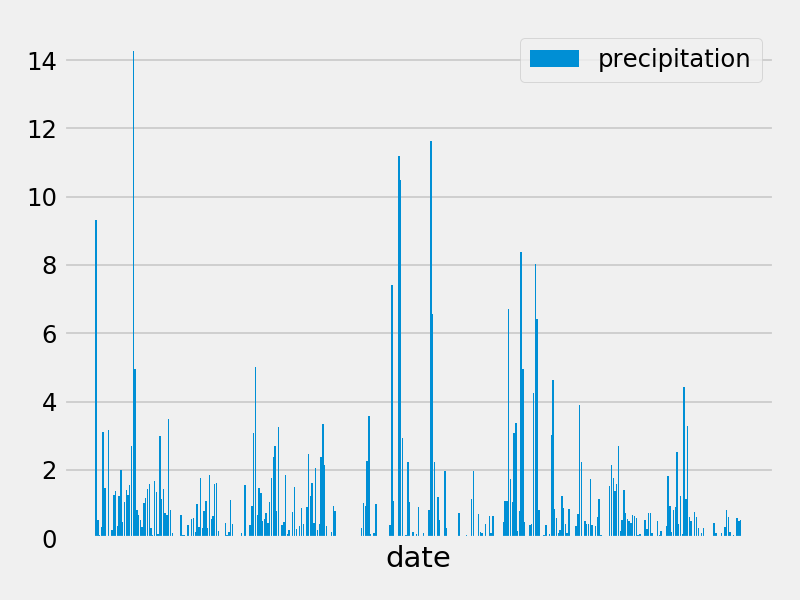

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data

plt.figure(0)
plt.bar(df_prcp["date"], df_prcp["sum_1"], label="precipitation")
plt.legend()
plt.xlabel("date")
plt.xticks([])
plt.tight_layout()
plt.show(0)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_prcp.describe()

,sum_1
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


In [13]:
# Design a query to show how many stations are available in this dataset?
qUniqueStations = session.query(Station.station).count()

print(qUniqueStations)

9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
qStationCount = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
for items in qStationCount:
    print(items)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

topStation = qStationCount[0][0]
topStationLength = qStationCount[0][1]
print(f"Station: {topStation}, Entries: {topStationLength}")

qTemps = session.query(Measurement.tobs).filter(Measurement.station == topStation).order_by(Measurement.tobs.desc())
highTemp = qTemps[0][0]
lowTemp = qTemps[topStationLength-1][0]

avgTemp = 0.0

for i in range(0,topStationLength):
    avgTemp = avgTemp + qTemps[i][0]

avgTemp = round(avgTemp/topStationLength, 1)

print(f"High: {highTemp}, Low: {lowTemp}, Avg: {avgTemp}")

Station: USC00519281, Entries: 2772
High: 85.0, Low: 54.0, Avg: 71.7


<IPython.core.display.Javascript object>


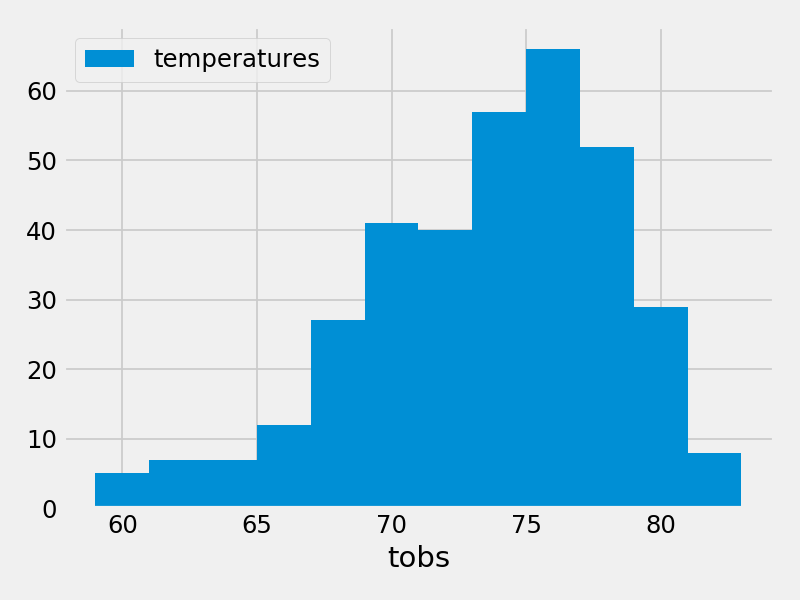

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobsData = session.query(Measurement.date, Measurement.tobs)\
.filter(Measurement.station==topStation).filter(Measurement.date > dateOld)\
.filter(Measurement.date <= dateNew).order_by(Measurement.date.asc())

# for items in tobsData:
#     print(items)

df_tobs = pd.read_sql(tobsData.statement, engine)
df_tobs.head()

plt.figure(1)
plt.hist(df_tobs["tobs"], bins=12, label="temperatures")
plt.legend()
plt.xlabel("tobs")
plt.tight_layout()
plt.show(1)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()[0]

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

(62.0, 69.57142857142857, 74.0)


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_avg = [calc_temps("2017-08-17", "2017-08-23")[0], calc_temps("2017-08-17", "2017-08-23")[1], calc_temps("2017-08-17", "2017-08-23")[2]]
print(trip_avg)

[71.0, 79.0, 85.0]


<IPython.core.display.Javascript object>


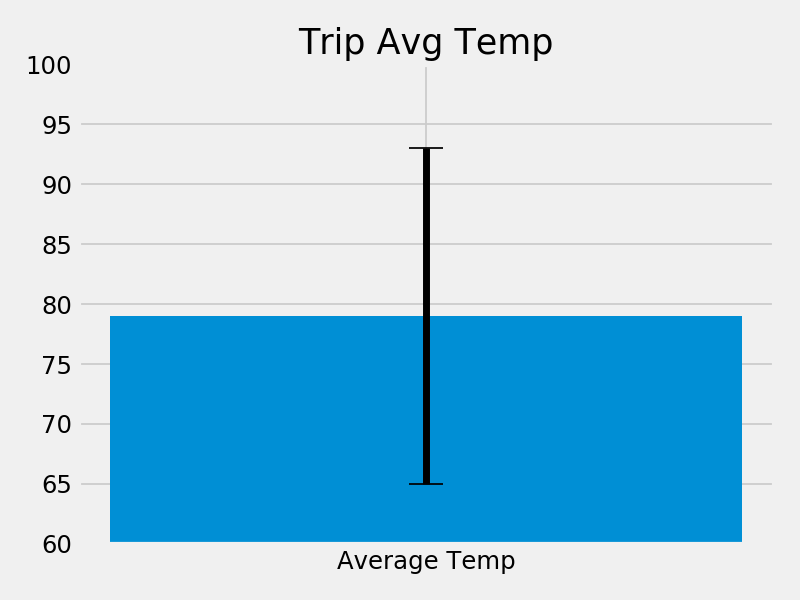

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x_data = "Average Temp"
y_data = trip_avg[1]
err = trip_avg[2] - trip_avg[0]
plt.figure(2)
plt.ylim(60,100)
plt.bar(x_data, y_data, yerr=err, ecolor="black", capsize=10)
plt.title("Trip Avg Temp")
plt.tight_layout()
plt.show(2)

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [24]:
# Plot the daily normals as an area plot with `stacked=False`
